In [1]:
import random 
import numpy as np 
import torch 
from utilities.pg_utils import set_seed
set_seed(111)

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
end_date = "2024-09-30"
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date, end_date=end_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
agent.pre_train()
# train the agent


pre-training ddpg agent started...
ReplayMemoryBuffer populating with experience...
pretraining done
buffer size: 13071


In [3]:
def calculate_total_return(equity_curve):
    """
    Calculate the total return from an equity curve.

    Args:
        equity_curve (list): List of portfolio values over time.

    Returns:
        float: Total return as a percentage.
    """
    V_start = equity_curve[0]
    V_end = equity_curve[-1]
    total_return = ((V_end - V_start) / V_start) * 100
    return total_return

In [4]:
calculate_total_return()

TypeError: calculate_total_return() missing 1 required positional argument: 'equity_curve'

In [5]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)


Training Started for DDPG Agent
Episode 1 - Actor Loss: 0.0660, Critic Loss: 0.6454, Total Reward: 1.8692
Episode 2 - Actor Loss: 0.0642, Critic Loss: 0.6564, Total Reward: 0.2323
Episode 3 - Actor Loss: 0.0657, Critic Loss: 0.6735, Total Reward: -2.0642
Episode 4 - Actor Loss: 0.0645, Critic Loss: 0.6899, Total Reward: 0.7204
Episode 5 - Actor Loss: 0.0644, Critic Loss: 0.7052, Total Reward: 0.8201
Episode 6 - Actor Loss: 0.0635, Critic Loss: 0.7215, Total Reward: 1.0046
Episode 7 - Actor Loss: 0.0603, Critic Loss: 0.7264, Total Reward: -0.1065
Episode 8 - Actor Loss: 0.0590, Critic Loss: 0.7338, Total Reward: 0.7929
Episode 9 - Actor Loss: 0.0586, Critic Loss: 0.7279, Total Reward: -0.1520
Episode 10 - Actor Loss: 0.0622, Critic Loss: 0.7587, Total Reward: 0.4105
Episode 11 - Actor Loss: 0.0593, Critic Loss: 0.7494, Total Reward: 0.8824
Episode 12 - Actor Loss: 0.0602, Critic Loss: 0.7608, Total Reward: 0.2693
Episode 13 - Actor Loss: 0.0581, Critic Loss: 0.7929, Total Reward: 0.5894

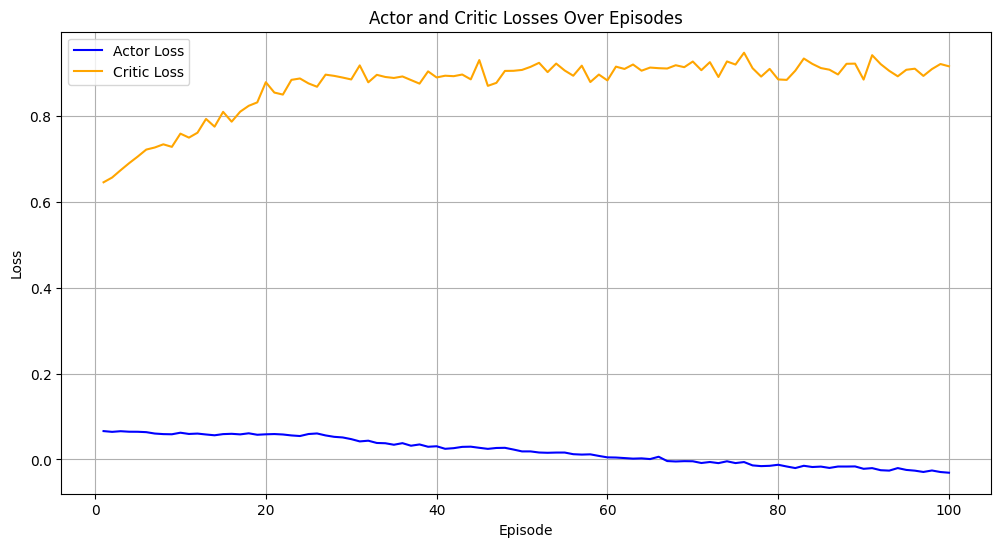

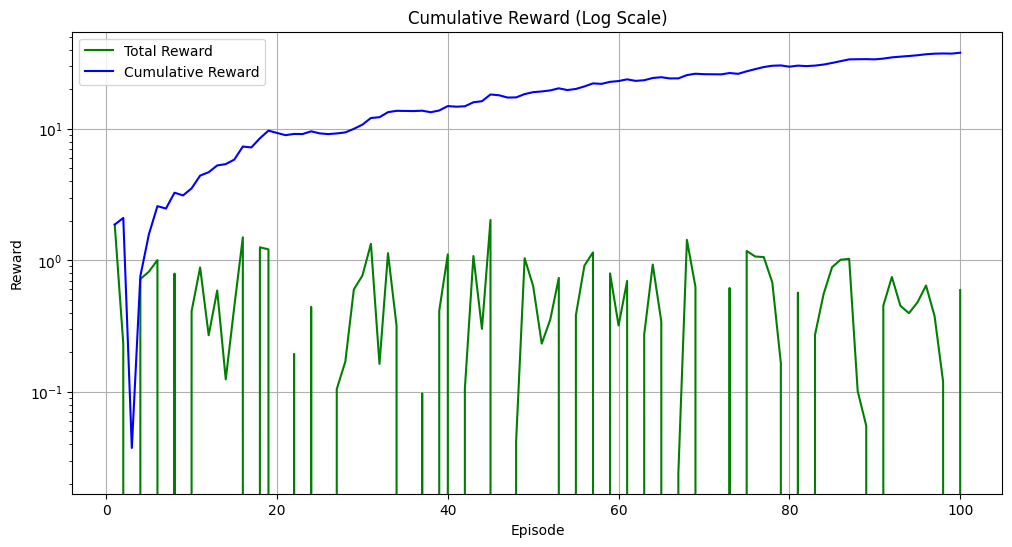

In [6]:
# train agent
agent.train(100);

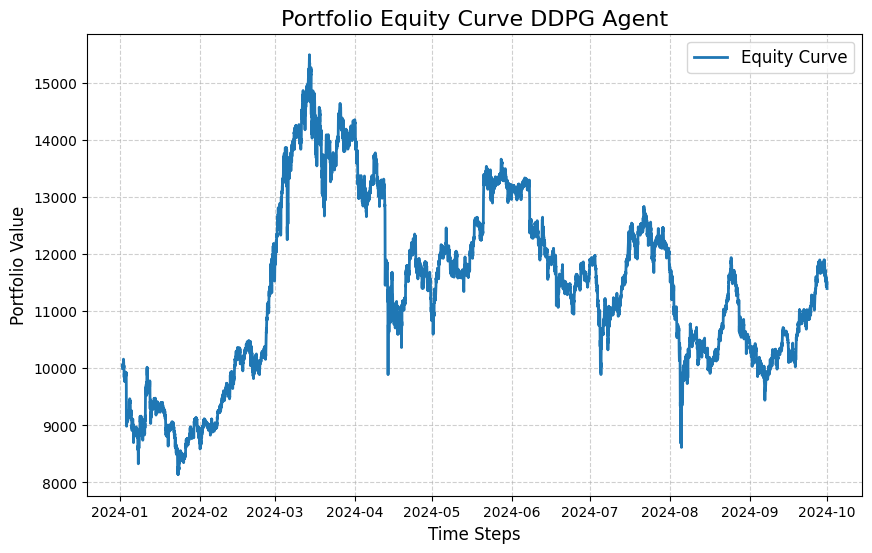

In [5]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index


pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []

for i in range(len(ds) + 48):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], agent_equity_curve, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()

In [4]:
calculate_total_return(agent_equity_curve)

NameError: name 'calculate_total_return' is not defined

In [9]:
calculate_total_return(agent_equity_curve)

73.18025390625

In [ ]:
portfolio.asset_names

In [10]:
weights[-5:]

[tensor([0.5359, 0.0437, 0.0416, 0.0434, 0.0423, 0.0423, 0.0406, 0.0419, 0.0426,
         0.0400, 0.0445, 0.0413], device='mps:0'),
 tensor([0.5979, 0.0379, 0.0364, 0.0374, 0.0367, 0.0367, 0.0351, 0.0361, 0.0370,
         0.0346, 0.0384, 0.0359], device='mps:0'),
 tensor([0.5930, 0.0379, 0.0372, 0.0381, 0.0371, 0.0369, 0.0357, 0.0359, 0.0375,
         0.0356, 0.0389, 0.0361], device='mps:0'),
 tensor([0.6022, 0.0372, 0.0361, 0.0376, 0.0359, 0.0358, 0.0347, 0.0351, 0.0368,
         0.0347, 0.0383, 0.0355], device='mps:0'),
 tensor([0.6041, 0.0369, 0.0357, 0.0376, 0.0357, 0.0358, 0.0346, 0.0340, 0.0368,
         0.0353, 0.0382, 0.0353], device='mps:0')]

In [ ]:
"""# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 48):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[50:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Portfolio Equity Curve Buy And Hold", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.show()
"""

In [3]:
rewards = [exp.reward for exp in agent.replay_memory.buffer]

Reward Min: -14.260293946249531, Reward Max: 13.20143135519574
Reward Mean: 0.021240092854266306, Reward Std: 0.9265191851598126


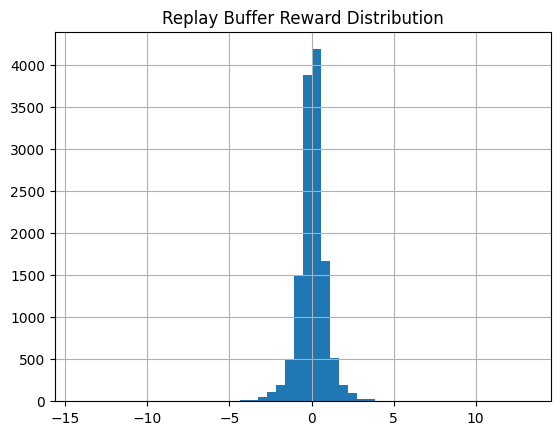

In [11]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [ ]:
np.random.uniform(
                -3, 3
            )  # Simulate expected reward range

In [9]:
portfolio.get_close_price().tail()

,CASH,SOL,ADA,USDT,AVAX,LINK,DOT,PEPE,ETH,XRP,TRX,MATIC
date,,,,,,,,,,,,
2024-09-30 21:30:00,1.0,155.74,0.381855,0.99972,28.12,11.98865,4.5220,0.000011,2610.90,0.62321,0.156490,0.4012
2024-09-30 22:00:00,1.0,155.08,0.378663,0.99975,27.90,11.91778,4.4855,0.000011,2603.98,0.61979,0.156499,0.3997
2024-09-30 22:30:00,1.0,154.38,0.376398,0.99985,27.78,11.88167,4.4676,0.000011,2602.70,0.61916,0.156578,0.3994
2024-09-30 23:00:00,1.0,153.54,0.375829,0.99976,27.86,11.87931,4.4503,0.000010,2600.53,0.61701,0.156499,0.3976
2024-09-30 23:30:00,1.0,152.66,0.373450,0.99973,27.74,11.85178,4.4363,0.000010,2602.97,0.61136,0.155978,0.3964
